# Creating Node Representations with DeepWalk


## First the inspiration: **Word2Vec**

!<img src="images/text2skip-grams.png" width="290" style="border:1px solid black">

In [1]:
import numpy as np

CONTEXT_SIZE = 2
text = """Lorem ipsum dolor sit amet, consectetur adipiscing elit. Nunc eu sem scelerisque, dictum eros aliquam, accumsan quam. Pellentesque tempus, lorem ut semper fermentum, ante turpis accumsan ex, sit amet ultricies tortor erat quis nulla. Nunc consectetur ligula sit amet purus porttitor, vel tempus tortor scelerisque. Vestibulum ante ipsum primis in faucibus orci luctus et ultrices posuere cubilia curae; Quisque suscipit ligula nec faucibus accumsan. Duis vulputate massa sit amet viverra hendrerit. Integer maximus quis sapien id convallis. Donec elementum placerat ex laoreet gravida. Praesent quis enim facilisis, bibendum est nec, pharetra ex. Etiam pharetra congue justo, eget imperdiet diam varius non. Mauris dolor lectus, interdum in laoreet quis, faucibus vitae velit. Donec lacinia dui eget maximus cursus. Class aptent taciti sociosqu ad litora torquent per conubia nostra, per inceptos himenaeos. Vivamus tincidunt velit eget nisi ornare convallis. Pellentesque habitant morbi tristique senectus et netus et malesuada fames ac turpis egestas. Donec tristique ultrices tortor at accumsan.
""".split()
skipgrams = []
for i in range(CONTEXT_SIZE, len(text) - CONTEXT_SIZE):
    array = [text[j] for j in range(i - CONTEXT_SIZE, i + CONTEXT_SIZE + 1) if j != i]
    skipgrams.append((text[i], array))
    
skipgrams[:2]

[('dolor', ['Lorem', 'ipsum', 'sit', 'amet,']),
 ('sit', ['ipsum', 'dolor', 'amet,', 'consectetur'])]

Imagine that we have a sequence of $N$ words:

$$
w_1, w_2, \dots, w_N
$$

The probability of seeing the word $w_2$ given the word $w_1$ is written as:

$$
p(w_2 | w_1)
$$

Our goal is to maximize the sum of every probability of seeing a context word given a target word in an entire text:

$$
\frac{1}{N} \sum_{n=1}^{N} \sum_{\substack{-c \leq j \leq c \\ j \neq 0}} \log p(w_{n+j} | w_n)
$$

Where $C$ is the size of the context vector.


The basic skip-gram model uses the softmax function to calculate the probability of a context word embedding $h_c$ given a target word embedding $h_t$:

$$
p(w_c | w_t) = \frac{\exp (h_c h_t^T)}{\sum_{i=1}^{|V|} \exp (h_i h_t^T)}
$$

Where $V$ is the vocabulary of size $|V|$. This vocabulary corresponds to the list of unique words the model tries to predict.


In [2]:
vocab = set(text)
VOCAB_SIZE = len(vocab)
print(f'Vocab size: {VOCAB_SIZE}')

Vocab size: 121


## This can be though of representation learning with auto encoders or like a self-learning task.

Now we have to define the dimensionality of the word vectors (embeddings) $N$ usually around 100 and 1000

The skip-gram model is composed of only two layers:

- A **projection layer** with a weight matrix $W_{embed}$, which takes a one-hot encoded word vector as an input and returns the corresponding $N$-dimensional word embedding. It acts as a simple lookup table that stores embeddings of a predefined dimensionality.

- A **fully connected layer** with a weight matrix $W_{output}$, which takes a word embedding as input and outputs $|V|$-dimensional logits. A softmax function is applied to these predictions to transform logits into probabilities.

**Note:** There is no activation function: Word2Vec is a linear classifier that models a linear relationship between words.

Let's call $\mathbf{x}$ the one-hot encoded-word vector (the **input**). The corresponding word embedding can be calculated as a simple projection:

$$
\mathbf{h} = W_{embed}^T \cdot \mathbf{x}
$$

Using the skip-gram model, we can rewrite the previous probability as follows:

$$
p(w_c | w_t) = \frac{\exp (W_{output} \cdot \mathbf{h})}{\sum_{i=1}^{|V|} \exp (W_{output(i)} \cdot \mathbf{h})}
$$

The skip-gram model outputs a $|V|$-dimensional vector, which is the conditional probability of every word in the vocabulary:

$$
\text{word2vec}(w_t) = \begin{bmatrix}
p(w_1 | w_t) \\
p(w_2 | w_t) \\
\vdots \\
p(w_{|V|} | w_t)
\end{bmatrix}
$$

During training, these probabilities are compared to the correct one-hot encoded target word vectors. The difference between these values (calculated by a loss function such as the cross-entropy loss) is backpropagated through the network to update the weights and obtain better predictions.


In [3]:
from gensim.models.word2vec import Word2Vec
model = Word2Vec([text], sg=1, vector_size=10, min_count=0, window=2, workers=2, seed=0)
# print the shape of the first weight matrix
print(f'Shape of model: {model.wv.vectors.shape}')

Shape of model: (121, 10)


In [4]:
model.train([text], total_examples=model.corpus_count, epochs=10)

(690, 1560)

In [5]:
print(f'Word embedding = {model.wv[0]}')

Word embedding = [ 0.07156403  0.03257632  0.00209916 -0.04374931 -0.03398107 -0.08656936
 -0.09047253 -0.0955243  -0.06482638  0.0660186 ]


---
## DeepWalk and Random Walks (Node Representations)
The goal of DeepWalk is to produce high-quality feature representations of nodes in an unsupervised way.

Why are random walks important? Even if nodes are randomly selected, the fact that they often appear together in a sequence means that they are close to each other. Under the network homophily hypothesis, nodes that are close to each other are similar. This is particularly the case in social networks, where people are connected to friends and family.

This idea is at the core of the DeepWalk algorithm: when nodes are close to each other, we want to obtain high similarity scores. On the contrary, we want low scores when they are farther apart.

In [6]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
random.seed(0)

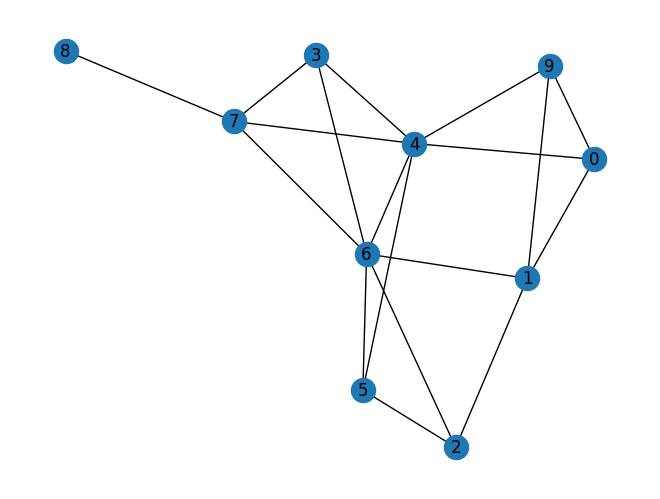

In [12]:
G = nx.erdos_renyi_graph(10, 0.3, seed=1, directed=False)
nx.draw(G, with_labels=True)
plt.show()

In [23]:
def random_walk(start, walk_length):
    walk = [str(start)]
    for i in range(walk_length):
        neighbors = [node for node in G.neighbors(start)]
        next_node = np.random.choice(neighbors, 1)[0]
        walk.append(str(next_node))
        start = next_node
    return walk
random_walk(0, 10)

['0', '10', '4', '0', '7', '1', '2', '0', '19', '0', '10']

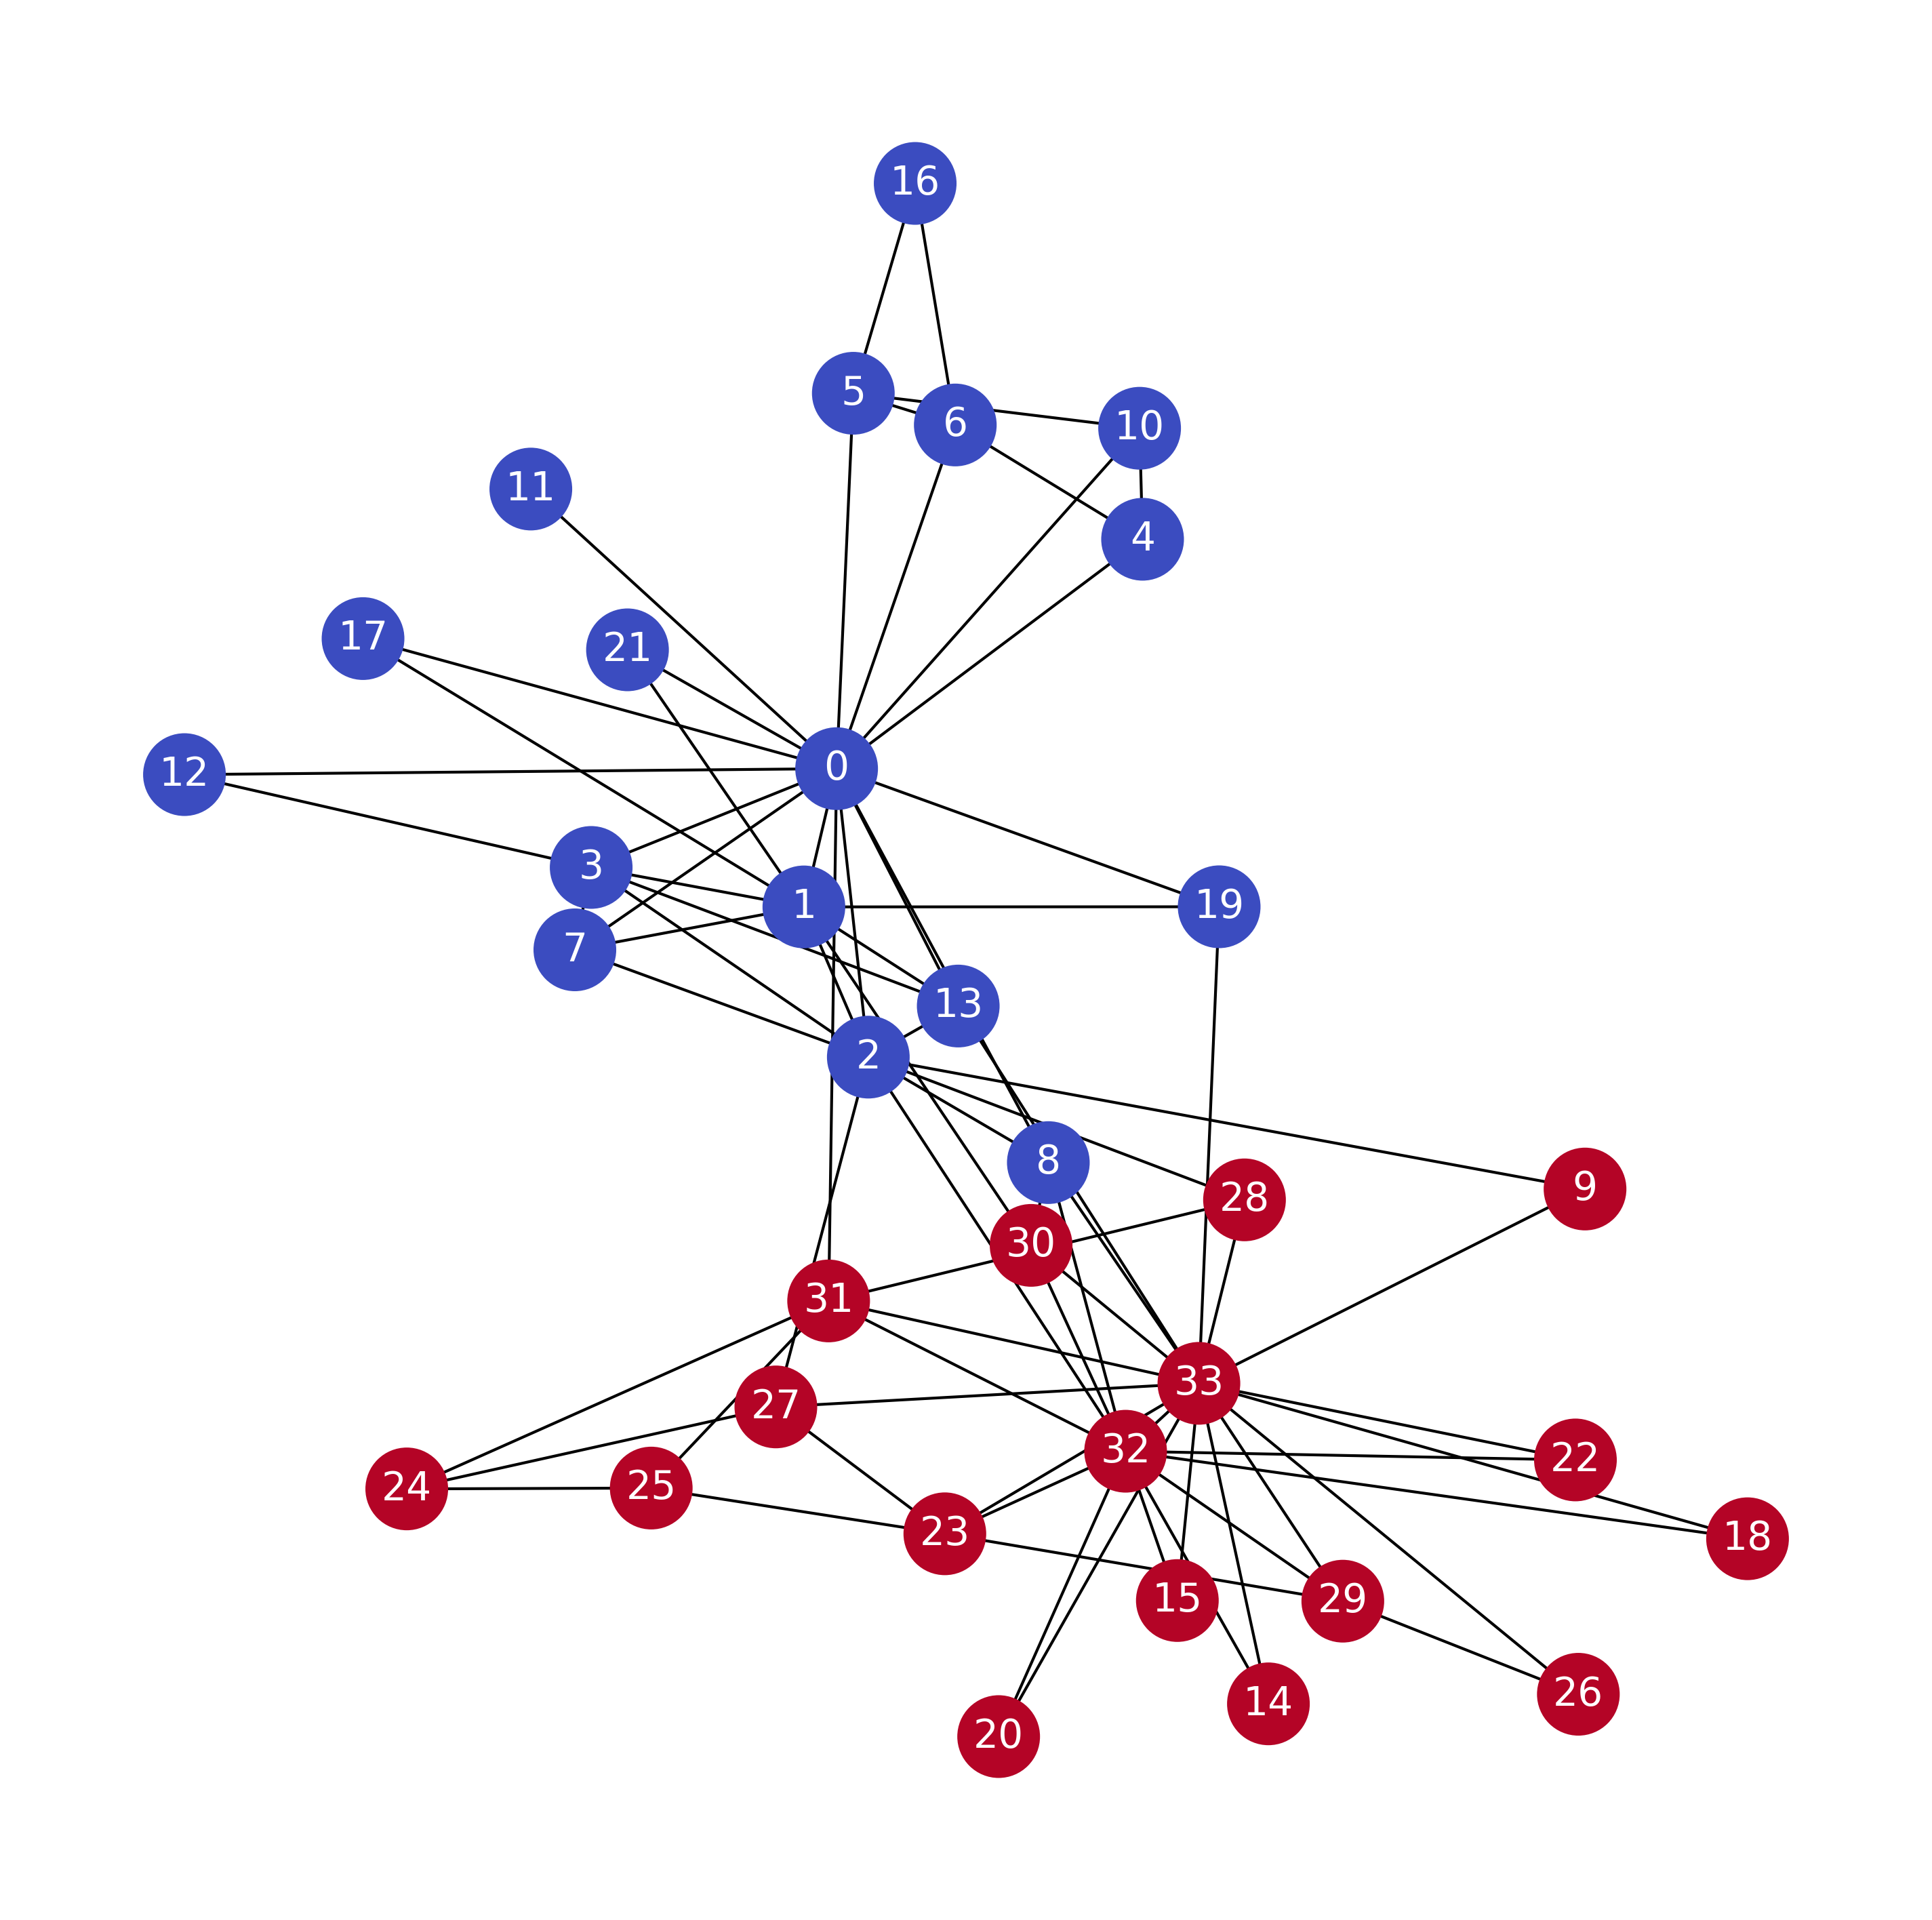

In [17]:
G = nx.karate_club_graph()
# convert string class labels into numbers
labels = []
for node in G.nodes:
    label = G.nodes[node]['club']
    labels.append(1 if label == 'Officer' else 0)
    
plt.figure(figsize=(12,12), dpi=300)
plt.axis('off')
nx.draw_networkx(G,
                 pos=nx.spring_layout(G, seed=0),
                 node_color=labels,
                 node_size=800,
                 cmap='coolwarm',
                 font_size=14,
                 font_color='white'
                 )

In [ ]:
# Now create the random walks
walks = []
for node in G.nodes:
    for _ in range(80):
        walks.append(random_walk(node, 10))
walks[:2]

In [28]:
model = Word2Vec(walks, hs=1, sg=1, vector_size=100, window=10, workers=2, seed=0)
model.train(walks, total_examples=model.corpus_count, epochs=30, report_delay=1)

(187388, 897600)

In [29]:
print('Nodes that are the most similar to node 0:')
for similarity in model.wv.most_similar(positive=['0']):
    print(f'   {similarity}')

Nodes that are the most similar to node 0:
   ('10', 0.6579102873802185)
   ('1', 0.6454664468765259)
   ('11', 0.6200838088989258)
   ('4', 0.6168282628059387)
   ('17', 0.610110342502594)
   ('6', 0.5746862292289734)
   ('21', 0.5742703676223755)
   ('12', 0.5642271637916565)
   ('7', 0.5376176834106445)
   ('5', 0.5341709852218628)


In [30]:
print(f"Similarity between node 0 and 4: {model.wv.similarity('0', '4')}")

Similarity between node 0 and 4: 0.6168282628059387


# Visualize Embeddings

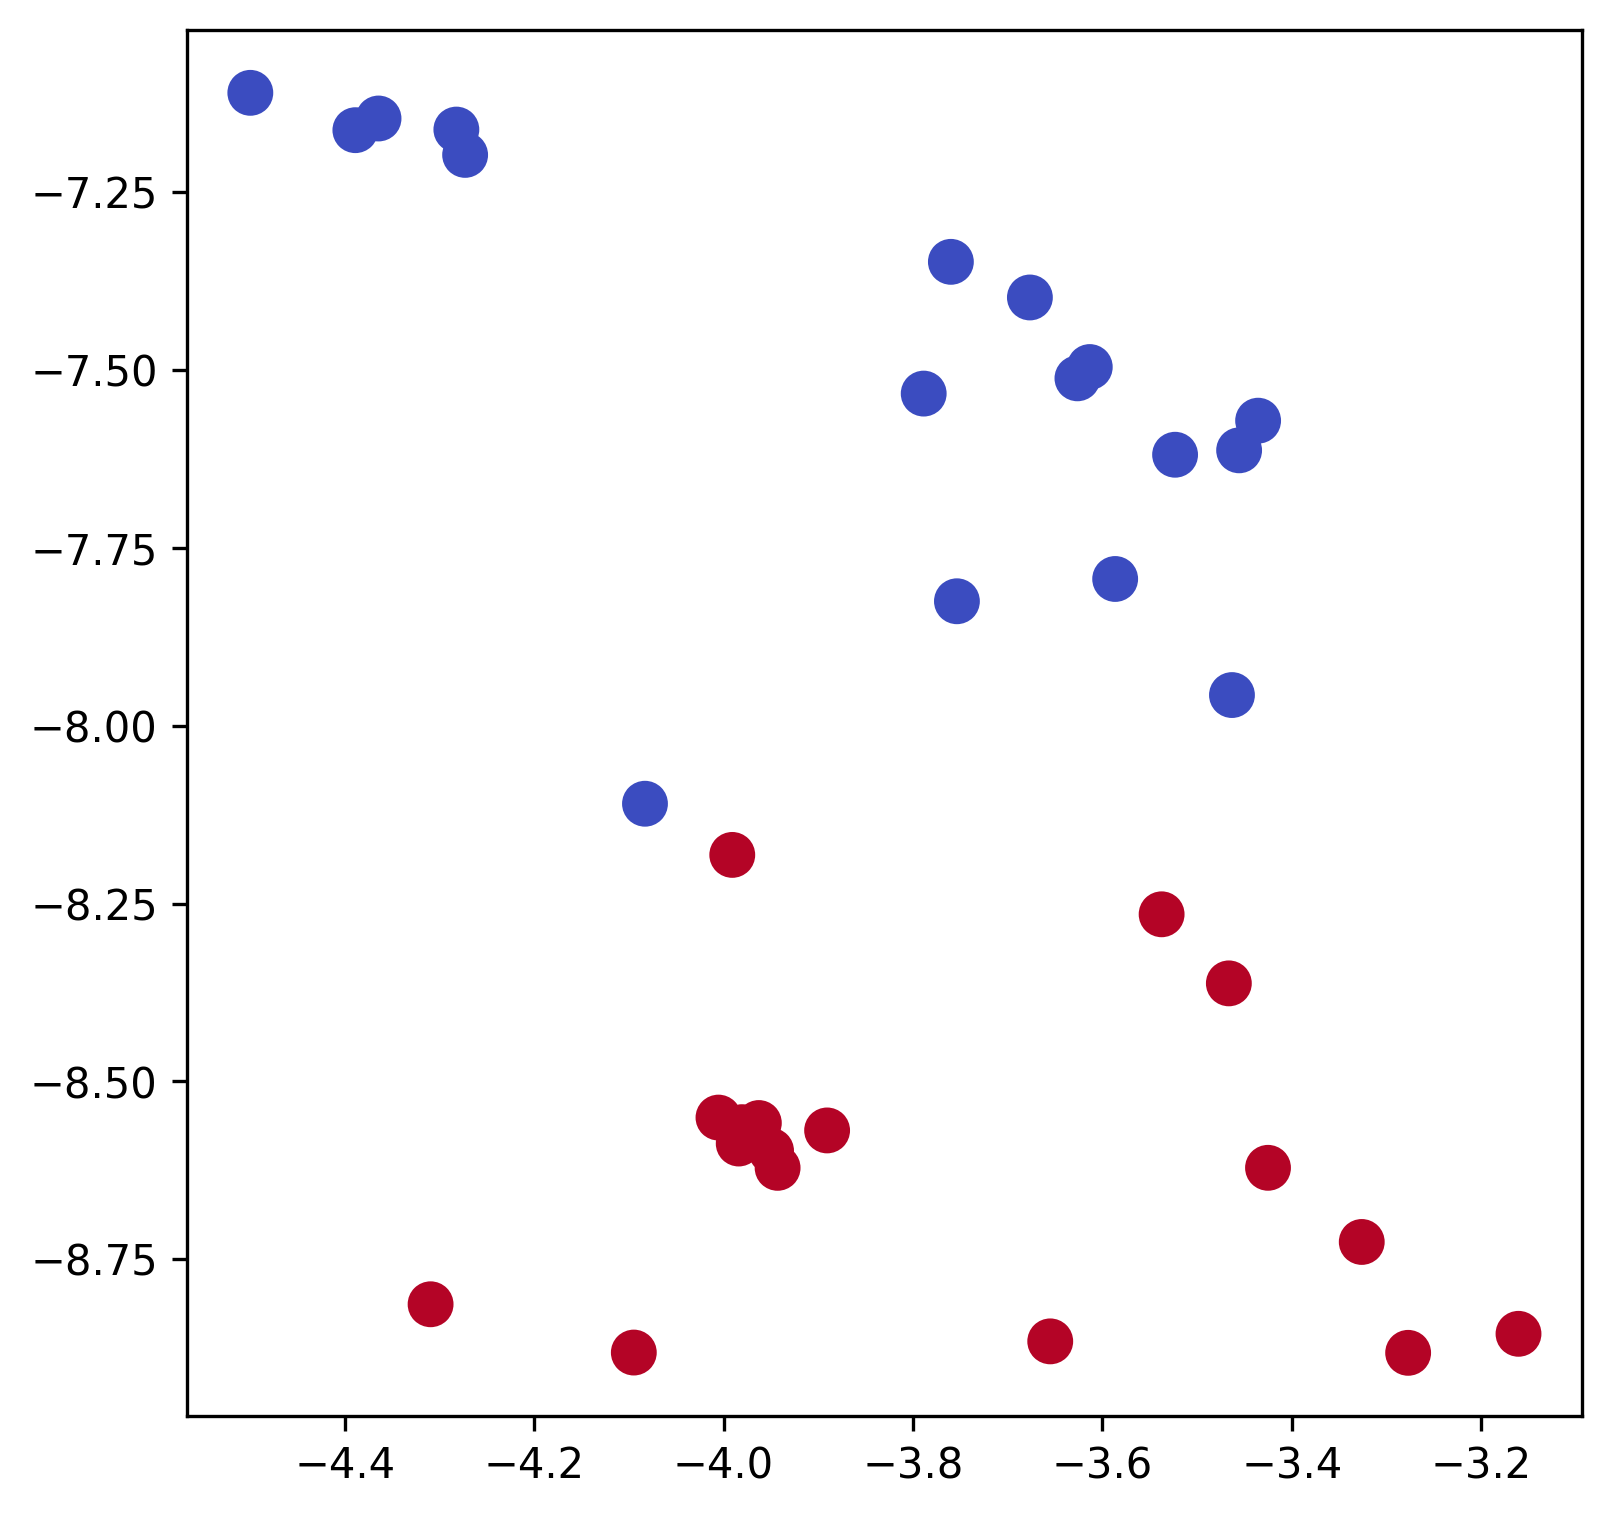

In [31]:
from sklearn.manifold import TSNE
nodes_wv = np.array([model.wv.get_vector(str(i)) for i in range(len(model.wv))])
labels = np.array(labels)

# Trains with 2 dims 
tsne = TSNE(n_components=2,
            learning_rate='auto',
            init='pca',
            random_state=0).fit_transform(nodes_wv)

plt.figure(figsize=(6, 6), dpi=300)
plt.scatter(tsne[:, 0], tsne[:, 1], s=100, c=labels, cmap="coolwarm")
plt.show()

In [32]:
# the are separable so classify them
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# train split
train_mask = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
test_mask = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 30, 31, 32, 33]

clf = RandomForestClassifier(random_state=0)
clf.fit(nodes_wv[train_mask], labels[train_mask])

RandomForestClassifier(random_state=0)

In [33]:
y_pred = clf.predict(nodes_wv[test_mask])
accuracy_score(y_pred, labels[test_mask])

0.9473684210526315